<a href="https://colab.research.google.com/github/Ashavennela/AICTE_ipnyb_project/blob/main/AICTE_FINAL_SUBMISSION_PROJECT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
# Step 1: Import Required Libraries

# For data manipulation and analysis
import pandas as pd  # data analytics
import numpy as np   # numerical data

# For data visualization
import seaborn as sns  # statistical data visualization
import matplotlib.pyplot as plt  # basic plotting
plt.style.use('fivethirtyeight')  # style for better visuals

# For splitting dataset and model evaluation
from sklearn.model_selection import train_test_split, GridSearchCV

# For machine learning algorithms
from sklearn.ensemble import RandomForestRegressor

# For model evaluation metrics
from sklearn.metrics import mean_squared_error, r2_score


In [20]:
import zipfile
import pandas as pd

# Path to your ZIP file
zip_path = "/content/archive (1).zip"

# Open the zip file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    # Get the list of files inside the zip
    file_list = zip_ref.namelist()
    print("Files inside ZIP:", file_list)

    # Select the first file from the list
    csv_file = file_list[0]
    print("Reading:", csv_file)

    # Extract only that file to /content
    zip_ref.extract(csv_file, "/content")

# Read the CSV into a pandas DataFrame
df = pd.read_csv(f"/content/{csv_file}")


Files inside ZIP: ['emissions_EU27.csv', 'emissions_EU28.csv']
Reading: emissions_EU27.csv


In [ ]:
# ================== DATA CLEANING PIPELINE ==================

import pandas as pd
import numpy as np

# 1. Inspect the dataset
print("First 5 rows:")
print(df.head())

print("\nLast 5 rows:")
print(df.tail())

print("\nDataset info:")
print(df.info())

print("\nSummary statistics:")
print(df.describe())

# 2. Remove duplicate rows
df.drop_duplicates(inplace=True)

# 3. Handle missing values
print("\nMissing values before cleaning:")
print(df.isnull().sum())

# Fill numeric NaN with median
df.fillna(df.median(numeric_only=True), inplace=True)

# Fill categorical NaN with mode
for col in df.select_dtypes(include=['object']).columns:
    if df[col].isnull().sum() > 0:
        df[col].fillna(df[col].mode()[0], inplace=True)

print("\nMissing values after filling:")
print(df.isnull().sum())

# 4. Standardize column names
df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_')

# 5. Fix data types (convert dates and numerics where possible)
for col in df.columns:
    # Try to convert to numeric
    df[col] = pd.to_numeric(df[col], errors='ignore')
    # If still object, try date conversion (skip if fails)
    if df[col].dtype == 'object':
        try:
            df[col] = pd.to_datetime(df[col])
        except:
            pass

# 6. Outlier removal for numeric columns using IQR
for col in df.select_dtypes(include=['float64', 'int64']).columns:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    df = df[(df[col] >= Q1 - 1.5 * IQR) & (df[col] <= Q3 + 1.5 * IQR)]

# 7. (Optional) One-hot encoding for categorical columns
# df = pd.get_dummies(df, drop_first=True)

print("\nData cleaning complete!")
print("Shape of cleaned data:", df.shape)


First 5 rows:
   airpol  cpa08  induse  origin  unit  geo\time         2019         2018  \
0       0      0       0       0     0         0        3.960        4.057   
1       0      0       0       0     1         0  1769659.000  1812055.000   
2       0      0       0       0     2         0     1769.659     1812.055   
3       0      0       0       1     0         0        0.745        0.741   
4       0      0       0       1     1         0   332721.000   331002.000   

          2017         2016         2015         2014  
0        4.120        4.067        3.944        3.745  
1  1836908.000  1810658.000  1752187.000  1660024.000  
2     1836.908     1810.658     1752.187     1660.024  
3        0.736        0.714        0.735        0.659  
4   328363.000   317759.000   326434.000   292046.000  

Last 5 rows:
        airpol  cpa08  induse  origin  unit  geo\time         2019  \
173659      23     66      11       1     1         0   683708.000   
173660      23     66      

/tmp/ipython-input-1039627296.py:43: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[col] = pd.to_numeric(df[col], errors='ignore')


Using file: emissions_EU27.csv


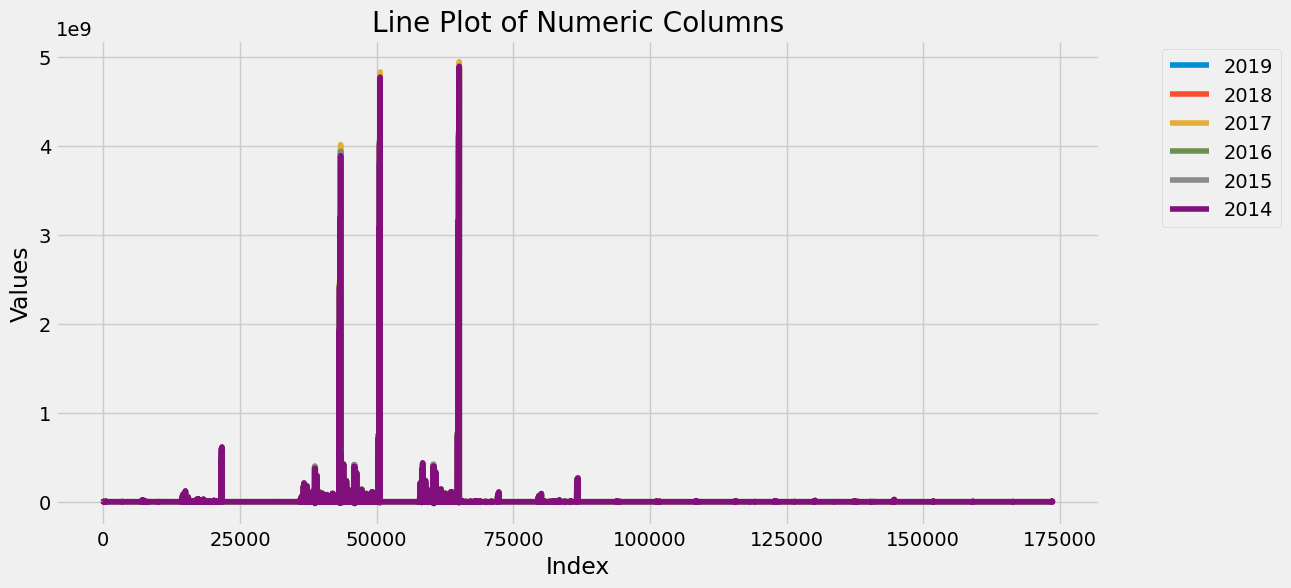

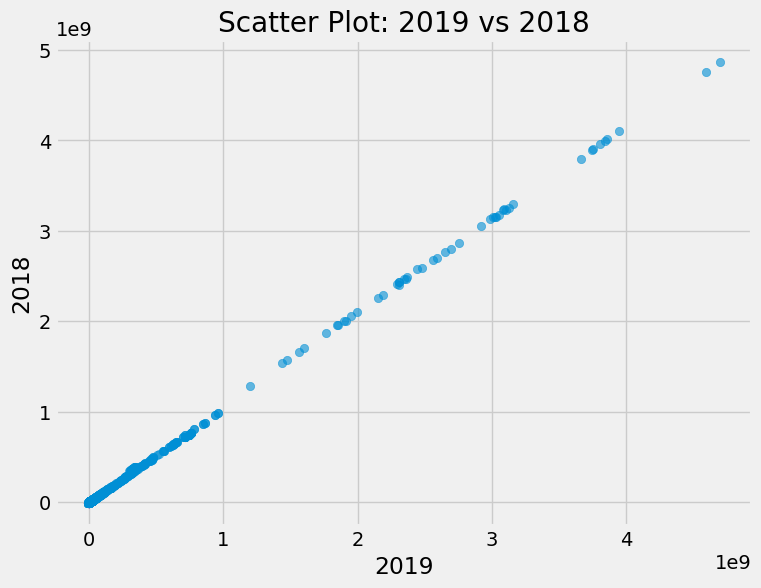

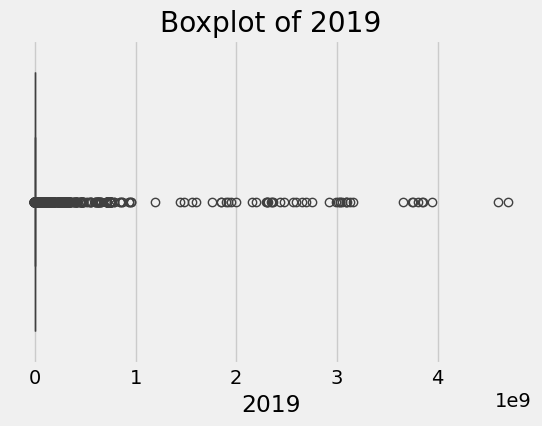

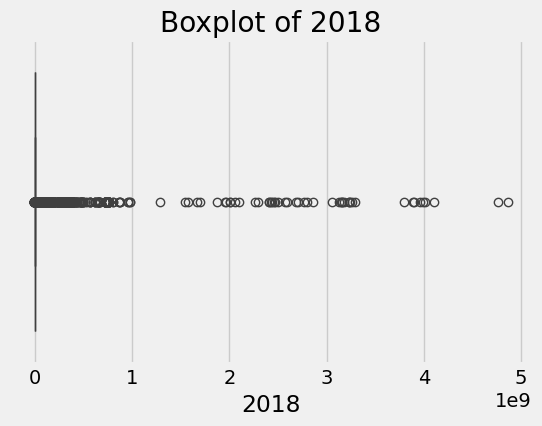

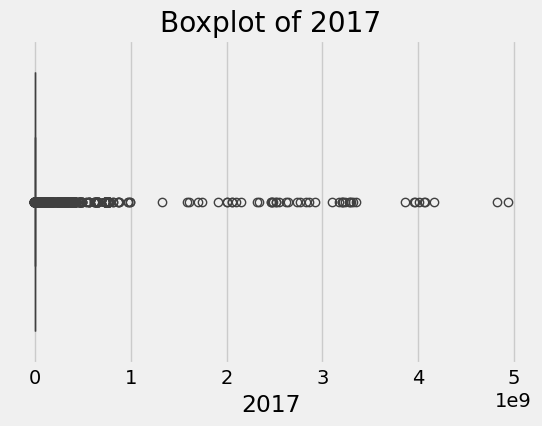

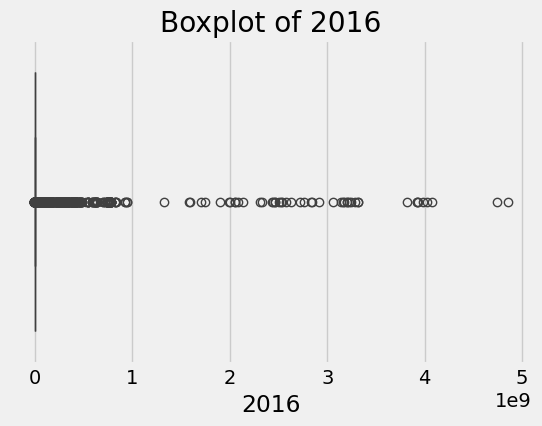

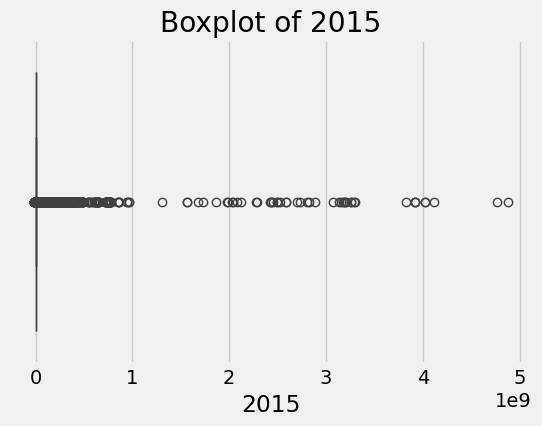

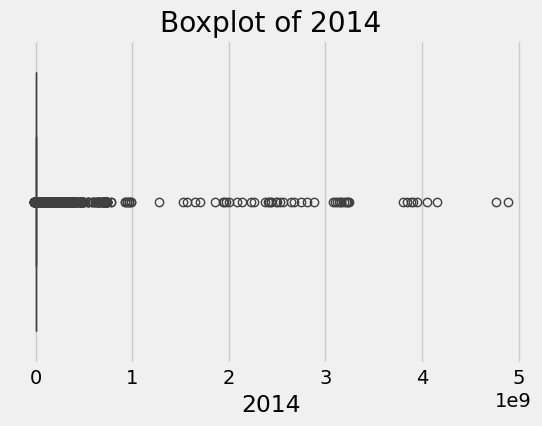

In [21]:
# ================== DATA VISUALIZATION (LINE, SCATTER, BOX PLOTS) ==================

import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('fivethirtyeight')

# Confirm the CSV file name
print("Using file:", csv_file)

# Select numeric columns
num_cols = df.select_dtypes(include=['float64', 'int64']).columns

# 1. Line plot for numeric columns
if len(num_cols) > 0:
    plt.figure(figsize=(12, 6))
    plt.plot(df[num_cols])
    plt.title("Line Plot of Numeric Columns")
    plt.xlabel("Index")
    plt.ylabel("Values")
    plt.legend(num_cols, bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()
else:
    print("No numeric columns available for line plot.")

# 2. Scatter plot (only if at least 2 numeric columns)
if len(num_cols) >= 2:
    plt.figure(figsize=(8, 6))
    plt.scatter(df[num_cols[0]], df[num_cols[1]], alpha=0.6)
    plt.title(f"Scatter Plot: {num_cols[0]} vs {num_cols[1]}")
    plt.xlabel(num_cols[0])
    plt.ylabel(num_cols[1])
    plt.show()
else:
    print("Not enough numeric columns for scatter plot.")

# 3. Box plots for each numeric column
if len(num_cols) > 0:
    for col in num_cols:
        plt.figure(figsize=(6, 4))
        sns.boxplot(x=df[col])
        plt.title(f'Boxplot of {col}')
        plt.show()
else:
    print("No numeric columns available for box plots.")


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import accuracy_score, r2_score

t = df.columns[-1]
for c in df.select_dtypes(include='object'):
    df[c] = LabelEncoder().fit_transform(df[c].astype(str))

X, y = df.drop(columns=[t]), df[t]
Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.2, random_state=42)

if y.dtype=='object' or len(y.unique())<=20:
    m = RandomForestClassifier().fit(Xtr, ytr)
    print("Accuracy:", round(accuracy_score(yte, m.predict(Xte))*100,2), "%")
else:
    m = RandomForestRegressor().fit(Xtr, ytr)
    p = m.predict(Xte)
    print("R²:", round(r2_score(yte, p),4))


Accuracy: 100.0 %
